In [23]:
import os
import random
import shutil

#from feature import * ??? for 'features' defined here if in other file?
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators import estimator
from tensorflow.contrib import learn

In [2]:
HOME = os.environ['HOME']
DATA_DIR = f'{HOME}/Learning/neuralNet/data/kaggle/titanic'
!ls $DATA_DIR

gender_submission.csv test.csv              train.csv


In [3]:
train = pd.read_csv(f'{DATA_DIR}/train.csv')
test = pd.read_csv(f'{DATA_DIR}/test.csv')
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [4]:
print(train.Survived.value_counts())
print(train.Survived.value_counts(normalize=True))

0    549
1    342
Name: Survived, dtype: int64
0    0.616162
1    0.383838
Name: Survived, dtype: float64


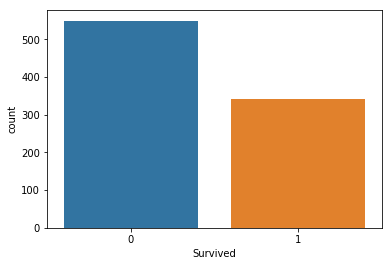

In [5]:
count_plot = sns.countplot(train.Survived)

In [6]:
train['NameTitle'] = train.Name\
    .apply(lambda x: x.split(',')[1])\
    .apply(lambda x: x.split()[0])
print(train['NameTitle'].value_counts())

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Mlle.          2
Col.           2
Lady.          1
Capt.          1
Ms.            1
the            1
Don.           1
Sir.           1
Mme.           1
Jonkheer.      1
Name: NameTitle, dtype: int64


In [7]:
print(train.Survived.groupby(train.NameTitle).mean())

NameTitle
Capt.        0.000000
Col.         0.500000
Don.         0.000000
Dr.          0.428571
Jonkheer.    0.000000
Lady.        1.000000
Major.       0.500000
Master.      0.575000
Miss.        0.697802
Mlle.        1.000000
Mme.         1.000000
Mr.          0.156673
Mrs.         0.792000
Ms.          1.000000
Rev.         0.000000
Sir.         1.000000
the          1.000000
Name: Survived, dtype: float64


In [8]:
train.Survived.groupby(train.Sex).mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [9]:
train['CabinLetter'] = train.Cabin.apply(lambda x: str(x)[0])
train.Survived.groupby(train.CabinLetter).mean()

CabinLetter
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64

In [10]:
train.Survived.groupby(train.Embarked).mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

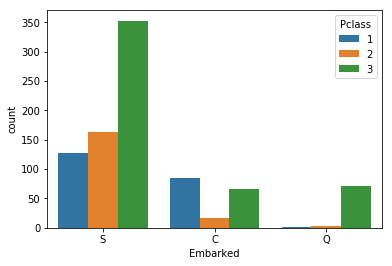

In [11]:
sns.countplot(train.Embarked, hue=train.Pclass);

In [12]:
def create_name_feat(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(len)
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1])\
            .apply(lambda x: x.split()[0])
        del i['Name']
    return train, test

In [13]:
def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(
            lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Name_Title', 'Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.median()))
    return train, test

In [14]:
def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where(
            (i['SibSp'] + i['Parch']) == 0, 'One',
            np.where((i['SibSp'] + i['Parch']) <= 3, 'Small', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test
        

In [26]:
def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Letr'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Letr'] = i['Ticket_Letr'].apply(str)
        i['Ticket_Letr'] = np.where(
            (i['Ticket_Letr']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']),
            i['Ticket_Letr'],
            np.where((i['Ticket_Letr'])\
                         .isin(['W', '4', '7', '6', 'L', '5', '8']),
                     'Low_ticket', 
                     'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(len)
        del i['Ticket']
    return train, test

In [16]:
def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

In [17]:
def embarked_impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train, test

In [18]:
def dummies(
        train, test, 
        columns=['Pclass', 'Sex', 'Embarked', 'Ticket_Letr', 
                 'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(str)
        test[column] = train[column].apply(str)
        good_cols = [column + '_' + i for i in train[column].unique() 
                     if i in test[column].unique()]
        train = pd.concat(
            (train, 
             pd.get_dummies(train[column], prefix=column)[good_cols]),
            axis=1)
        test = pd.concat(
            (test, 
             pd.get_dummies(test[column], prefix=column)[good_cols]),
            axis=1)
        del train[column]
        del test[column]
    return train, test

In [19]:
def PrepareTarget(data):
    return np.array(data.Survived, dytpe='int8').reshape(-1, 1)

# Logistic Regression
### Using `tf.contrib`

```
model_params = {'learning_rate': LEARNING_RATE}
nn = tf.contrib.learn.Estimator(model_fn=model_fn, 
                                params=model_params)
```

In [28]:
random.seed(1103)
train = pd.read_csv(f'{DATA_DIR}/train.csv')
test = pd.read_csv(f'{DATA_DIR}/test.csv')

In [29]:
train, test = create_name_feat(train, test)
train, test = age_impute(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].median(), inplace=True)
train, test = ticket_grouped(train, test)